    MSE : 두 **점** 사이의 **거리**  
    CEE : 데이터 **확률분포** P와, P를 이용해 계산한 **확률분포** Q 간의 **차이**  
      Q의 확률이 1에 가까울 수록 패널티를 적게 주고,  
      0에 가까울 수록 패널티를 급격하게 준다  

**CEE 최소화 -> KLD 최소화 -> 추정한 분포 Q와 데이터 분포 P의 차이 최소화**


In [32]:
normal * np.log(poisson + 1)

array([-0.04856697, -0.14111949,  1.46028959,  0.91165119,  0.        ,
        0.88501305,  0.38285408,  0.5519683 ,  1.60215103,  0.        ])

<AxesSubplot:ylabel='Density'>

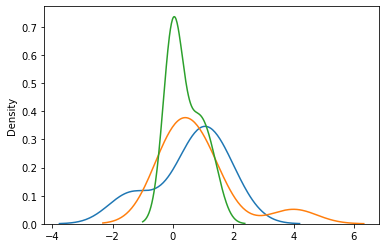

In [35]:
import numpy as np
import seaborn as sns

normal = np.random.normal(1, 1, 10)
poisson = np.random.poisson(1, 10)

sns.kdeplot(normal)
sns.kdeplot(poisson)
sns.kdeplot(normal * np.log(poisson + 1))

## 국민청원 실습

In [4]:
# 크롤링
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time

result = pd.DataFrame()
for i in range(584274, 595226):
    url = 'https://www1.president.go.kr/petitions/' + str(i)
    response = requests.get(url).content
    soup = BeautifulSoup(response, 'html.parser')
    title = soup.find('h3', class_='petitionsView_title')
    count = soup.find('span', class_='counter')
    
    for content in soup.select('div.petitionsView_write > div.View_write'):
        a = []
        for tag in soup.select('ul.petitionsView_info_list > li'):
            a.append(tag.contents)
            
        if len(a) != 0:
            df1 = pd.DataFrame({'start':[a[1]],
                               'end':[a[2]],
                               'category':[a[0]],
                               'count':[count.text],
                               'title':[title.text],
                               'content':[content.text.strip()[0:13000]]})
            result = pd.concat([result, df1])
            result.index = np.arange(len(result))
            
        if i % 60 == 0:
            print('sleep 90s. Count:' + str(i) + ', Local Time:', time.strftime('%Y-%m-%d', time.localtime(time.time())),
                 time.strftime('%X', time.localtime(time.time())), ', Data Length:', str(len(result)))
            time.sleep(90)

In [9]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time

df = pd.read_csv('./프로젝트 데이터 모음/petition.csv')[:7756]

In [10]:
import re

def remove_sp_wh(text):
    p = re.compile(r'([\t\r\n\f\v])|([^ ㄱ-ㅣ가-힣0-9]+)')
    text = p.sub(' ', str(text))
    return text

df.title = df.title.apply(remove_sp_wh)
df.content = df.content.apply(remove_sp_wh)

In [11]:
from konlpy.tag import Okt
okt = Okt()

df['title_token'] = df.title.apply(okt.morphs)
df['content_token'] = df.content.apply(okt.nouns)

df['token_final'] = df.title_token + df.content_token
df['count'] = df['votes'].replace({',' : ''}, regex=True).apply(lambda x : int(x))
df['label'] = df['count'].apply(lambda x: 'Yes' if x>=1000 else 'No')

In [12]:
df_drop = df[['token_final', 'label']].copy()

### 임베딩 벡터

In [5]:
from gensim.models import Word2Vec, KeyedVectors

embedding_model = Word2Vec(df_drop['token_final'],
                          sg=1,
                          vector_size=100,
                          window=2,
                          min_count=1)

model_result = embedding_model.wv.most_similar('음주')
print(model_result)

/home/jaehoon/anaconda3/envs/torch_env/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [26]:
embedding_model.syn1neg.shape

((20720, 100),)

In [6]:
embedding_model.wv.save_word2vec_format('petition_token_w2v')

loaded_model = KeyedVectors.load_word2vec_format('petition_token_w2v')

### 데이터 분할 & Field

In [13]:
from numpy.random import RandomState
import torchtext
from torchtext.data import Field

rng = RandomState()
tr = df_drop.sample(frac=.8, random_state=rng)
val = df_drop.loc[~df_drop.index.isin(tr.index)]

# ['토큰1', '토큰2', ...] 형태로 데이터를 return 해줘야 함
# [[토큰1, 토큰2], [토큰3, 토큰4, 토큰5]] 괄호 하나 제거해줘야 함
def tokenizer(text):
    text = re.sub('[\[\]\']', '', str(text))
    text = text.split(', ')
    return text

TEXT = Field(tokenize=tokenizer)
LABEL = Field(sequential=False)